# Ego-Vision 손동작 인식 경진대회

## Overview

본 대회를 참가하기 이전에도 데이콘을 포함하여 다양한 컴페티션을 참여하면서 Model이나 Training technique을 적용하는 위주로 대회를 참여했었습니다.  
이번 대회를 계기로 다시 한 번 데이터를 직접 보면서 분석하고 살펴보는 것이 중요하다는 것을 느낄 수 있는 대회였습니다.

- Image(w/ keypoint)를 사용한 Classification 모델을 Base로 많은 방법들을 시도해보았고, 확실한 효과를 봤던 기법들을 순서대로 정리하자면 아래와 같습니다.
    - Rule-based Approach : Public-0.00670, Private score-0.00578 (아래에서 자세히 분석하겠지만 큰 효과를 봤습니다.)
    - Flip Augmentation
    - Random Margin Crop Image
    - Random Affine & Random Perspective Augmentation
    - OneCycleLR Scheduler
    - WarmUpLR Scheduler

<br>

- 최종적으로 제출한 2가지는 5Fold Ensemble 결과 하나와 Validation이 가장 잘나온 Single Fold 모델 하나(추론 시간까지 고려했었습니다)를 제출했습니다.
- Private 결과가 나왔을 때는 신기하게도 Single Fold 모델 하나가 선택되었습니다. 본 대회가 테스트셋이 217개로 매우 적다보니 모델 결과에도 운이 꽤 작용하는 것 같습니다.
- 다만 안정적인 재현을 위해 해당 코드는 5Fold Ensemble로 작성하였고, Best Single Fold(0~4폴드 중 4폴드)모델은 Github에서 Pretrained Weight을 불러오도록 하였습니다.
- 최종 결과: 5Fold Ensemble - Public:0.00627 / Single Best - Public:0.00670, Private:0.00578    (대회가 끝난 후 5Fold의 Private 결과는 알 수 없는 점이 조금 아쉬웠습니다.)

## 0. Prerequisites

## 0-1. Requirements
Ubuntu 18.04, Cuda 11

- opencv-python  
- numpy  
- pandas
- timm
- torch==1.8.0 torchvision 0.9.0 with cuda 11.1
- natsort
- scikit-learn==1.0.0
- pillow
- torch_optimizer
- tqdm
- ptflops
- easydict
- matplotlib

## 0-2 Directory 구조

In [1]:
import os
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))
list_files('../')

/
src_notebook/
    FDAI_1st place solution.ipynb
    1st place solution.ipynb
data/
    df_train_add.csv
    df_train.csv
    sample_submission.csv
    hand_gesture_pose.csv
    train/
        0/
            1.png
            7.png
            2.png
            4.png
            0.json
            8.png
            5.png
            3.png
            0.png
            9.png
            6.png
        1/
            1.json
            1.png
            2.png
            4.png
            5.png
            3.png
            0.png
            6.png
    test/
        649/
            1.png
            2.png
            4.png
            649.json
            5.png
            3.png
            0.png
            6.png
        650/
            1.png
            7.png
            2.png
            4.png
            8.png
            5.png
            3.png
            0.png
            650.json
            9.png
            6.png


## 0-3. Import Library

In [7]:
import os
import cv2
import json
import time
import random
import logging
import easydict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from pathlib import Path
from natsort import natsorted
from os.path import join as opj
from ptflops import get_model_complexity_info
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from PIL import Image

import timm
import torch
import torch.nn as nn
import torch_optimizer as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, grad_scaler
from torchvision import transforms

import warnings
warnings.filterwarnings('ignore')


## 0-4. Config

모델 및 학습의 Hyper-parameter를 정의합니다.

In [8]:
args = easydict.EasyDict(
    {'exp_num':'0',
     'experiment':'Base',
     'tag':'Default',

     # Path settings
     'data_path':'../data',
     'fold':4,
     'Kfold':5,
     'model_path':'results/',

     # Model parameter settings
     'encoder_name':'regnety_040',
     'drop_path_rate':0.2,
     
     # Training parameter settings
     ## Base Parameter
     'img_size':288,
     'batch_size':16,
     'epochs':60,
     'optimizer':'Lamb',
     'initial_lr':5e-6,
     'weight_decay':1e-3,

     ## Augmentation
     'aug_ver':2,
     'flipaug_ratio':0.3,
     'margin':50,
     'random_margin':True,

     ## Scheduler
     'scheduler':'cycle',
     'warm_epoch':5,
     ### Cosine Annealing
     'min_lr':5e-6,
     'tmax':145,
     ### OnecycleLR
     'max_lr':1e-3,

     ## etc.
     'patience':50,
     'clipping':None,

     # Hardware settings
     'amp':True,
     'multi_gpu':False,
     'logging':False,
     'num_workers':4,
     'seed':42
    })

## 1. Make dataset

Dataset

In [9]:
# keypoint를 기준으로 이미지를 crop하기 위한 함수 정의
# train과 test시 해당 함수가 적용된 crop이미지가 inputs으로 들어가게 됩니다.
def crop_image(imges, point, margin=100):
    image = np.array(Image.open(imges).convert('RGB'))
    point = point['data']
    max_point = np.max(np.array(point), axis=0).astype(int) + margin
    min_point = np.min(np.array(point), axis=0).astype(int) - margin
    max_point = max_point[:-1] # remove Z order
    min_point = min_point[:-1] # remove Z order

    max_x, max_y = max_point
    min_x, min_y = min_point
    max_y += margin  # 손목까지
    
    # 데이터 포인트의 크기가 원 이미지를 넘어서는 경우를 방지
    max_x = max_x if max_x < 1920 else 1920
    max_y = max_y if max_y < 1080 else 1080
    min_x = min_x if min_x > 0 else 0
    min_y = min_y if min_y > 0 else 0
    
    crop_image = image[min_y:max_y, min_x:max_x]

    return crop_image

In [10]:
# dataloader에서 사용할 dataframe 만들기
train_path = '../data/train'
train_folders = natsorted(glob(train_path + '/*'))

answers = []
for train_folder in train_folders:
    json_path = glob(train_folder + '/*.json')[0]
    js = json.load(open(json_path))
    cat = js.get('action')[0]
    cat_name = js.get('action')[1]
    
    images_list = glob(train_folder + '/*.png')
    for image_name in images_list:
        answers.append([image_name, cat, cat_name])

answers = pd.DataFrame(answers, columns = ['train_path','answer', 'answer_name'])
answers.to_csv('../data/df_train.csv', index=False)

# 클래스가 1개뿐인 폴더들 Augmentation해서 이미지 생성후 dataframe재정의
# 새롭게 정의한 dataframe을 학습에 이용시 약간의 성능향상을 확인할 수 있었음.
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)

data_path = '../data'
df_train = pd.read_csv(opj(data_path, 'df_train.csv'))
df_info = pd.read_csv(opj(data_path, 'hand_gesture_pose.csv'))
df_train = df_train.merge(df_info[['pose_id', 'gesture_type', 'hand_type']],
                        how='left', left_on='answer', right_on='pose_id')

save_folder = 'train' 
for i in range(649, 649+5):
    if not os.path.exists(opj(data_path, save_folder, str(i))):
        os.makedirs(opj(data_path, save_folder, str(i)))

# flip aug가능한 label : 131, 47 (one sample)
oslabel_fliplabel = [(131,156), (47, 22)] # one sample label, flip label
folders = ['649', '650'] # Train 648번 folder에 이은 number 생성
for label, folder in tqdm(zip(oslabel_fliplabel, folders)):
    idx = 0
    os_label, f_label  = label[0], label[1]
    one_sample = df_train[df_train['answer'] == os_label].reset_index(drop=True)
    temp = df_train[df_train['answer'] == f_label].reset_index(drop=True)
    train_folders = natsorted(temp['train_path'].apply(lambda x : x[:-6]).unique())
    for train_folder in (train_folders):
        json_path = glob(train_folder + '/*.json')[0]
        js = json.load(open(json_path))
        keypoints = js['annotations']
        images_list = natsorted(glob(train_folder + '/*.png'))
        for _, (point, image_name) in enumerate(zip(keypoints, images_list)):
            croped_image = crop_image(image_name, point, margin=50)
            flip_img = cv2.flip(croped_image, 1)
            save_path = opj(data_path, save_folder, folder, f'{idx}.png')
            idx += 1
            cv2.imwrite(save_path, flip_img)
            df_train.loc[len(df_train)] = [save_path] + one_sample.iloc[0][1:].values.tolist()

def rotation(img, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h)) 
    return img

oslabel = [92, 188, 145]
folder = ['651', '652', '653']
for label, folder in tqdm(zip(oslabel, folder)):
    idx = 0
    one_sample = df_train[df_train['answer'] == label].reset_index(drop=True)
    train_folders = natsorted(temp['train_path'].apply(lambda x : x[:-6]).unique())
    for train_folder in (train_folders):
        json_path = glob(train_folder + '/*.json')[0]
        js = json.load(open(json_path))
        keypoints = js['annotations']
        images_list = natsorted(glob(train_folder + '/*.png'))
        for _, (point, image_name) in enumerate(zip(keypoints, images_list)):
            croped_image = crop_image(image_name, point, margin=50)
            aug_img = rotation(croped_image, 30)
            save_path = opj(data_path, save_folder, folder, f'{idx}.png')
            idx += 1
            cv2.imwrite(save_path, aug_img)
            df_train.loc[len(df_train)] = [save_path] + one_sample.iloc[0][1:].values.tolist()

df_train.to_csv('../data/df_train_add.csv', index=False)

2it [00:02,  1.01s/it]
3it [00:03,  1.26s/it]


## Dataset & Loader (Flip Augmentation & Crop using the keypoints & Remove noise keypoints)
- Keypoint로 Crop하는 코드는 5252님의 코드 공유를 참고하였습니다. 공유해주셔서 감사합니다. (https://dacon.io/competitions/official/235805/codeshare/3362?page=1&dtype=recent)
- 저희는 여러 Margin 값에 대해서도 실험을 해보기 위해 이미지를 미리 잘라놓지 않고 Original Image를 불러서 Crop하는 방식으로 Pytorch의 Dataset을 구성했습니다.

In [7]:
# Train dataset에 475, 543 폴더는 의도하지 않은 나머지 손에 대해서도 Keypoint가 잡히게 됨.
# Json의 Keypoint를 사용하기위해 475,543폴더인 경우 해당 부분 Keypoint 제거
def remove_keypoints(folder_num, points):
    lst = []
    for x,y,z in points:
        cond1 = x<250 and y>800
        cond2 = x>1400 and y<400
        if not (cond1 or cond2):
           lst.append([x,y,z]) 
    # print('Finished removing {} wrong keypoints....'.format(folder_num))
    return lst

class Train_Dataset(Dataset):
    def __init__(self, df, transform=None, df_flip_info=None, flipaug_ratio=0, label_encoder=None, margin=50, random_margin=True):
        self.id = df['train_path'].values
        self.target = df['answer'].values
        self.transform = transform
        self.margin = margin
        self.random_margin = random_margin

        # Flip Augmentation (Change target class)
        if df_flip_info is not None:
            self.use_flip = True
            print('Use Flip Augmentation')
            left = label_encoder.transform(df_flip_info['left'])
            right = label_encoder.transform(df_flip_info['right'])
            left_to_right = dict(zip(left, right))
            right_to_left = dict(zip(right, left))
            
            self.flip_info = left_to_right.copy()
            self.flip_info.update(right_to_left)        
            self.flip_possible_class = list(set(np.concatenate([left, right])))
        self.flipaug_ratio = flipaug_ratio

        print(f'Dataset size:{len(self.id)}')

    def __getitem__(self, idx):
        image = np.array(Image.open(self.id[idx]).convert('RGB'))
        target = self.target[idx]

        # Load Json File
        try:
            image_num = int(Path(self.id[idx]).stem)
            dir = os.path.dirname(self.id[idx])
            folder_num = os.path.basename(dir)
            json_path = opj(dir, folder_num+'.json')
            js = json.load(open(json_path))
            keypoints = js['annotations'][image_num]['data']  # 해당 이미지에 해당하는 Keypoints
        except:  # Augmentation으로 직접 새로 만든 Folder는 Json이 없으므로 바로 Return (미리 손 부분이 Crop된 상태로 저장하였음.)
            image = self.transform(Image.fromarray(image))
            return image, np.array(target)

        if folder_num in ['475', '543']:
            keypoints = remove_keypoints(folder_num, keypoints)

        # Image Crop using keypoints
        max_point = np.max(np.array(keypoints), axis=0).astype(int) + self.margin
        min_point = np.min(np.array(keypoints), axis=0).astype(int) - self.margin
        max_point = max_point[:-1] # remove Z order
        min_point = min_point[:-1] # remove Z order

        max_x, max_y = max_point
        min_x, min_y = min_point
        max_y += 100  # 손목부분까지 여유를 주기위해

        # 매 에폭마다 Margin이 조금씩 다르게 들어가므로 한 폴더 내 비슷한 이미지들의 Overfitting을 방지하는 효과를 주기위해 (Only Train Phase)
        if self.random_margin:  
            if random.random() < 0.5:
                max_x += self.margin
            if random.random() < 0.5:
                max_y += self.margin
            if random.random() < 0.5:
                min_x -= self.margin
            if random.random() < 0.5:
                min_y -= self.margin
        else:
            max_x += self.margin
            max_y += self.margin
            min_x -= self.margin
            min_y -= self.margin

        # 데이터 포인트의 크기가 원 이미지를 넘어서는 경우를 방지
        max_x = max_x if max_x < 1920 else 1920
        max_y = max_y if max_y < 1080 else 1080
        min_x = min_x if min_x > 0 else 0
        min_y = min_y if min_y > 0 else 0
        
        image = image[min_y:max_y, min_x:max_x]

        # FlipAug
        if (random.random() < self.flipaug_ratio) and (target in self.flip_possible_class):
            image = np.flip(image, axis=1)  # (H, W, C)에서 width 축 flip
            target = self.flip_info[target]

        image = self.transform(Image.fromarray(image))
        return image, np.array(target)

    def __len__(self):
        return len(self.id)

def get_loader(df, batch_size, shuffle, num_workers, transform, df_flip_info=None, 
                flipaug_ratio=0, label_encoder=None, margin=50, random_margin=True):
    dataset = Train_Dataset(df, transform, df_flip_info=df_flip_info, flipaug_ratio=flipaug_ratio, 
                            label_encoder=label_encoder, margin=margin, random_margin=random_margin)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=True,
                                drop_last=False)
    return data_loader

def get_train_augmentation(img_size, ver):
    if ver==1:
        # For Test
        transform = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
                ])


    if ver==2:
        # For Train
        transform = transforms.Compose([
                transforms.RandomAffine(20),
                transforms.RandomPerspective(),
                transforms.ToTensor(),
	            transforms.Resize((img_size, img_size)),
    	        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]),
            ])


    return transform

## Flip Augmentation
- 중복된 데이터가 많아 오버피팅이 빠르게 발생하여 적절한 Augmentation을 수행해야 했습니다.
- 평소 이미지 Task에서 흔하게 사용되는 Augmentation인 Horizontal Flip은 사용할 수 없었습니다. (동일한 포즈라도 왼손, 오른손 Class가 다르기 때문에)
- 저희는 이 부분을 고민하다가 동일한 포즈일 때, 이미지는 Horizontal Flip을 시키고 Class 역시 바꾸어주면 충분히 학습에 사용할 수 있을거라 생각했습니다.
- 예를 들면, My View, 왼손, 그리고 숫자1일 때 HFlip을 수행하여 My View, 오른손, 숫자 1이라는 클래스를 만들어 주었습니다.
- 이를 구현하기 위해, 미리 아래와 같은 Mapping dataframe을 만들어 주었고 Pytorch dataset안에 이식하였습니다.
- 이 때, Flip augmentation을 수행하는 비율을 0.1~0.5로 다양하게 해보았을 때 0.3이 가장 적절하였습니다.
- 추가로 위와 비슷하게 양손인 경우 한 손을 Crop하여 새로운 Class를 부여하는 방법도 구현하여 사용하였는데 잘 작동하지 않아서 최종적으로는 사용하지 않았습니다.

## Network
pytorch image models(timm) 라이브러리를 활용하여 Generalization Performance에 강점을 가지는 RegNet을 Base 모델로 사용하였습니다.

In [8]:
class Pose_Network(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.encoder = timm.create_model(args.encoder_name, pretrained=True,
                                    drop_path_rate=args.drop_path_rate,
                                    )
        num_head = self.encoder.head.fc.in_features
        self.encoder.head.fc = nn.Linear(num_head, 157)
    
    def forward(self, x):
        return self.encoder(x)

## Utils for training and Logging
Logging과 AvgMeter를 통해 실험 기록을 log파일로 남도록 저장하였습니다.  
추가로 실험마다 비교를 쉽게 하기위해 Neptune을 활용하였는데 코드에서는 제거하였습니다.

In [9]:
# Warmup Learning rate scheduler
from torch.optim.lr_scheduler import _LRScheduler
class WarmUpLR(_LRScheduler):
    """warmup_training learning rate scheduler
    Args:
        optimizer: optimzier(e.g. SGD)
        total_iters: totoal_iters of warmup phase
    """
    def __init__(self, optimizer, total_iters, last_epoch=-1):
        
        self.total_iters = total_iters
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        """we will use the first m batches, and set the learning
        rate to base_lr * m / total_iters
        """
        return [base_lr * self.last_epoch / (self.total_iters + 1e-8) for base_lr in self.base_lrs]

# Logging
def get_root_logger(logger_name='basicsr',
                    log_level=logging.INFO,
                    log_file=None):

    logger = logging.getLogger(logger_name)
    # if the logger has been initialized, just return it
    if logger.hasHandlers():
        return logger

    format_str = '%(asctime)s %(levelname)s: %(message)s'
    logging.basicConfig(format=format_str, level=log_level)

    if log_file is not None:
        file_handler = logging.FileHandler(log_file, 'w')
        file_handler.setFormatter(logging.Formatter(format_str))
        file_handler.setLevel(log_level)
        logger.addHandler(file_handler)

    return logger

class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.losses = []

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        self.losses.append(val)


## Trainer
모델의 학습(training function)과 검증(Validation)을 위한 Class입니다.  

In [10]:
class Trainer():
    def __init__(self, args, save_path):
        '''
        args: arguments
        save_path: Model 가중치 저장 경로
        '''
        super(Trainer, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Logging
        log_file = os.path.join(save_path, 'log.log')
        self.logger = get_root_logger(logger_name='IR', log_level=logging.INFO, log_file=log_file)
        self.logger.info(args)
        self.logger.info(args.tag)

        # Train, Valid Set load
        ############################################################################
        # df_train = pd.read_csv(opj(args.data_path, 'df_train.csv'))
        df_train = pd.read_csv(opj(args.data_path, 'df_train_add.csv'))
        df_info = pd.read_csv(opj(args.data_path, 'hand_gesture_pose.csv'))

        df_train = df_train.merge(df_info[['pose_id', 'gesture_type', 'hand_type']], \
                                how='left', left_on='answer', right_on='pose_id')

        # 폴더별(Group)로 각 번호 부여
        df_train['groups'] = df_train['train_path'].apply(lambda x:x.split('/')[3])
        df_train.loc[:,:] = natsorted(df_train.values)
        # 노이즈 이미지 제거: 596번은 주먹쥐기 이미지인데 갑자기 손바닥을 펴는 노이즈 이미지가 5장있음 + 0번 폴더에 9번 이미지 역시 잘못된 클래스
        drop_idx = df_train[df_train['groups'].isin(['596'])].index.tolist()[3:8] + [9]  
        df_train = df_train.drop(drop_idx).reset_index(drop=True)  
        le = LabelEncoder()
        df_train['answer'] = le.fit_transform(df_train['answer'])
        
        # Split Fold
        # kf = StratifiedGroupKFold(n_splits=args.Kfold)
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=args.seed)
        for fold, (train_idx, val_idx) in enumerate(kf.split(df_train, y=df_train['answer'])):
            df_train.loc[val_idx, 'fold'] = fold
        df_val = df_train[df_train['fold'] == args.fold].reset_index(drop=True)
        df_train = df_train[df_train['fold'] != args.fold].reset_index(drop=True)
        
        # Augmentation
        self.train_transform = get_train_augmentation(img_size=args.img_size, ver=args.aug_ver)
        self.test_transform = get_train_augmentation(img_size=args.img_size, ver=1)
        
        ######################################################################
        # Flip Augmentation을 위한 Mapping dataframe
        df_info = pd.read_csv('../data/hand_gesture_pose.csv')
        df_info = df_info[df_info['hand_type'] != 'both']
        # drop idx, 동일한 약속, gesture_type, hand_type인데 다른 클래스인 경우 존재 -> 약속 1과 2로 이름을 나누어줌.
        df_info.loc[[105, 128], 'pose_name'] = '약속 1'  # idx: (105, 128)
        df_info.loc[[101, 124], 'pose_name'] = '약속 2'  # idx: (101, 124)

        # drop 41 idx, 동일한 약속, my hand, right class가 49와 54로 두 개있어 Mapping df만들 때 문제가 발생하여 미리 49번 클래스 처리
        df_info = df_info.drop(41)

        # Make a mapping dataframe
        df_info = df_info.groupby(['pose_name', 'view_type', 'gesture_type', 'hand_type']).sum().unstack().reset_index().dropna(axis=0)
        df_info['left'] = df_info.pose_id.left.apply(int)
        df_info['right'] = df_info.pose_id.right.apply(int)
        df_flip_info = df_info.drop('pose_id', axis=1).droplevel('hand_type', axis=1).reset_index(drop=True)
        print('Mapping dataframe Length', df_flip_info.shape)
        ######################################################################
        
        # TrainLoader
        self.train_loader = get_loader(df_train, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, transform=self.train_transform, 
                                       df_flip_info=df_flip_info, flipaug_ratio=args.flipaug_ratio, label_encoder=le, margin=args.margin, random_margin=args.random_margin)
        self.val_loader = get_loader(df_val, batch_size=args.batch_size, shuffle=False,
                                       num_workers=args.num_workers, transform=self.test_transform)

        # Network
        self.model = Pose_Network(args).to(self.device)
        macs, params = get_model_complexity_info(self.model, (3, args.img_size, args.img_size), as_strings=True,
                                                 print_per_layer_stat=False, verbose=False)
        self.logger.info('{:<30}  {:<8}'.format('Computational complexity: ', macs))
        self.logger.info('{:<30}  {:<8}'.format('Number of parameters: ', params))

        # Loss
        self.criterion = nn.CrossEntropyLoss()
        
        # Optimizer & Scheduler
        self.optimizer = optim.Lamb(self.model.parameters(), lr=args.initial_lr, weight_decay=args.weight_decay)
        
        iter_per_epoch = len(self.train_loader)
        self.warmup_scheduler = WarmUpLR(self.optimizer, iter_per_epoch * args.warm_epoch)

        if args.scheduler == 'cos':
            tmax = args.tmax # half-cycle 
            self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max = tmax, eta_min=args.min_lr, verbose=True)
        elif args.scheduler == 'cycle':
            self.scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, max_lr=args.max_lr, steps_per_epoch=iter_per_epoch, epochs=args.epochs)

        
        if args.multi_gpu:
            self.model = nn.DataParallel(self.model).to(self.device)

        # Train / Validate
        best_loss = np.inf
        best_acc = 0
        best_epoch = 0
        early_stopping = 0
        start = time.time()
        for epoch in range(1, args.epochs+1):
            self.epoch = epoch

            if args.scheduler == 'cos':
                if epoch > args.warm_epoch:
                    self.scheduler.step()

            # Training
            train_loss, train_acc = self.training(args)

            # Model weight in Multi_GPU or Single GPU
            state_dict= self.model.module.state_dict() if args.multi_gpu else self.model.state_dict()

            # Validation
            val_loss, val_acc = self.validate()

            # Save models
            if val_loss < best_loss:
                early_stopping = 0
                best_epoch = epoch
                best_loss = val_loss
                best_acc = val_acc

                torch.save({'epoch':epoch,
                            'state_dict':state_dict,
                            'optimizer': self.optimizer.state_dict(),
                            'scheduler': self.scheduler.state_dict(),
                    }, os.path.join(save_path, 'best_model.pth'))
                self.logger.info(f'-----------------SAVE:{best_epoch}epoch----------------')
            else:
                early_stopping += 1

            # Early Stopping
            if early_stopping == args.patience:
                break

        self.logger.info(f'\nBest Val Epoch:{best_epoch} | Val Loss:{best_loss:.4f} | Val Acc:{best_acc:.4f}')
        end = time.time()
        self.logger.info(f'Total Process time:{(end - start) / 60:.3f}Minute')


    # Training
    def training(self, args):
        self.model.train()
        train_loss = AvgMeter()
        train_acc = 0

        scaler = grad_scaler.GradScaler()
        for i, (images, targets) in enumerate(tqdm(self.train_loader)):
            images = torch.tensor(images, device=self.device, dtype=torch.float32)
            targets = torch.tensor(targets, device=self.device, dtype=torch.long)
            
            if self.epoch <= args.warm_epoch:
                self.warmup_scheduler.step()

            self.model.zero_grad(set_to_none=True)
            if args.amp:
                with autocast():
                    preds = self.model(images)
                    loss = self.criterion(preds, targets)
                scaler.scale(loss).backward()

                # Gradient Clipping
                if args.clipping is not None:
                    scaler.unscale_(self.optimizer)
                    nn.utils.clip_grad_norm_(self.model.parameters(), args.clipping)

                scaler.step(self.optimizer)
                scaler.update()

            else:
                preds = self.model(images)
                loss = self.criterion(preds, targets)
                loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), args.clipping)
                self.optimizer.step()

            if args.scheduler == 'cycle':
                if self.epoch > args.warm_epoch:
                    self.scheduler.step()

            # Metric
            train_acc += (preds.argmax(dim=1) == targets).sum().item()
            # log
            train_loss.update(loss.item(), n=images.size(0))
            
        train_acc /= len(self.train_loader.dataset)

        self.logger.info(f'Epoch:[{self.epoch:03d}/{args.epochs:03d}]')
        self.logger.info(f'Train Loss:{train_loss.avg:.3f} | Acc:{train_acc:.4f}')
        return train_loss.avg, train_acc
            
    # Validation or Dev
    def validate(self):
        self.model.eval()
        with torch.no_grad():
            val_loss = AvgMeter()
            val_acc = 0

            for _, (images, targets) in enumerate(self.val_loader):
                images = torch.tensor(images, device=self.device, dtype=torch.float32)
                targets = torch.tensor(targets, device=self.device, dtype=torch.long)

                preds = self.model(images)
                loss = self.criterion(preds, targets)

                # Metric
                val_acc += (preds.argmax(dim=1) == targets).sum().item()
                # log
                val_loss.update(loss.item(), n=images.size(0))
            val_acc /= len(self.val_loader.dataset)

            self.logger.info(f'Valid Loss:{val_loss.avg:.3f} | Acc:{val_acc:.4f}')
        return val_loss.avg, val_acc


## Stratified GroupKFold Split
- 데이터셋을 살펴보면 총 이미지가 5888개이지만, 한 폴더내의 이미지가 대부분 비슷한 것을 확인할 수 있습니다.
- 이러한 데이터를 일반적인 Split 방법으로 나눌 경우 Validation Accuracy가 거의 1에 가깝게 나오게되어 어떤 Class를 잘 못맞추는지에 대한 분석을 수행할 수 없었습니다.
- 따라서, 저희는 각 폴더별로 Group을 부여하고 해당 Group 전체가 Train or Valid로 들어가게하는 GroupKFold를 사용하였고, 추가적으로 Class Label 분포를 고려하기위해 Stratified KFold를 함께 적용했습니다.
- 이를 통해, 단일 모델로 대회 중간에 Public 기준으로 0.024라는 좋은 스코어를 얻을 수 있었습니다.
- 다만, 그 이후에 Fold를 다르게 하여 학습한 경우 Public score가 0.15~0.20 정도로 매우 극심한 차이를 보였습니다.
- 확인해보니 전체 데이터 중 특정 클래스가 1,2개 폴더만 존재하는 클래스가 있었는데, GroupKFold로 Split시에 특정 클래스는 Train에만, 또는 Valid에만 들어가는 것을 현상을 확인했고 이는 특정 클래스에는 대해 검증을 수행할 수 없게되는 문제가 있었습니다.

- 이를 방지하기 위해 위 Make dataset section에서 볼 수 있듯이 폴더가 1개인 클래스를 폴더가 2개 이상이 되도록 만들어 주었는데, 이 때 단순히 Augmentation을 사용한게 아니라 Flip Augmentation(+Rotation) 수행하였습니다.

## Validation prediction의 분포 확인
- 위 방법을 통해 적절한 Train/Valid Split을 수행한 후에도 여전히 Fold별 편차가 심한 것을 확인하였습니다.
- 따라서, 모델이 어떤 클래스를 못 맞추었는지에 대한 분석을 진행하였습니다.
- 분석 결과 특정 몇개 클래스에서 Logloss값이 매우 크게 발생하는 것을 확인하였고 Insight를 얻기위해 해당 클래스들의 이미지를 살펴보았습니다.

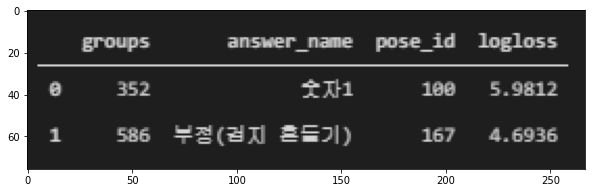

In [40]:
## Case1
# img = Image.open('./etc/숫자1_검지흔들기.png')
# plt.figure(figsize=(10,5))
# plt.imshow(img)

- 나머지 클래스 예측에 대한 logloss 값은 대부분 0.1보다 작은 값을 보여주지만 숫자1과 검지 흔들기에 대해서는 매우 큰 logloss를 보여줍니다.

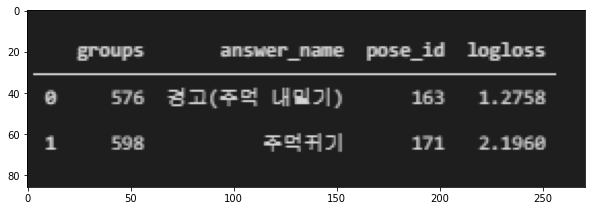

In [41]:
## Case2
# img = Image.open('./etc/주먹내밀기_주먹쥐기.png')
# plt.figure(figsize=(10,5))
# plt.imshow(img)

In [13]:
# 시각화를 위한 Function
def visualize(folder_num):
    path = f'../data/train/{folder_num}/*.png'
    image_list = glob(path)
    length = len(image_list)
    
    fig, ax = plt.subplots(1, length, figsize=(50,10))
    for i, image in enumerate(image_list):
        image = Image.open(image).convert('RGB')
        ax[i].imshow(image)
    plt.show()

In [14]:
df = pd.read_csv(opj(args.data_path, 'df_train.csv'))
df['groups'] = df['train_path'].apply(lambda x:x.split('/')[3])
df = df.drop_duplicates('groups')

### (Case 1) 첫 번째는 숫자1과 부정(검지 흔들기) 대해 큰 Logloss값이 발생한 것을 볼 수 있습니다.

아래 시각화를 보시면 두 이미지는 각각 숫자1과 부정(검지 흔들기) Class입니다.

352 489


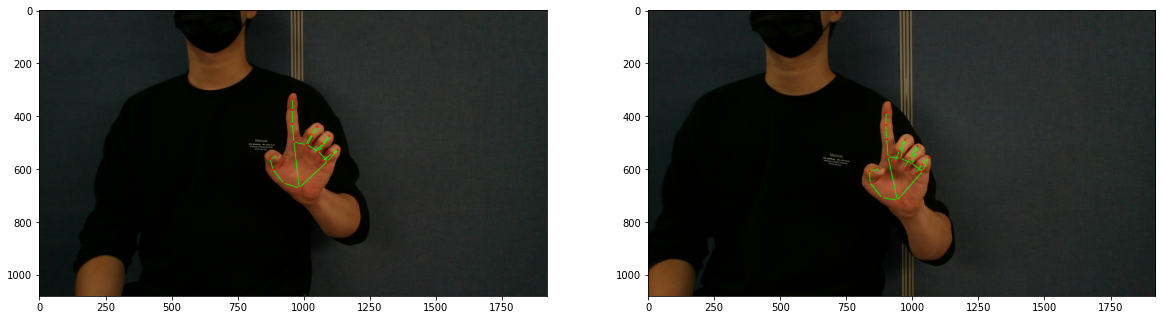

In [15]:
path = f'../data/train/'
number1_folder = df[df['answer_name'] == '숫자1']['groups'].tolist()
shake_folder = df[df['answer_name'] == '부정(검지 흔들기)']['groups'].tolist()

image1 = Image.open(opj(path, number1_folder[0], '1.png'))   # 352번 폴더
image2 = Image.open(opj(path, shake_folder[11], '1.png'))    # 489번 폴더
print(number1_folder[0], shake_folder[11])

fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(image1)
ax[1].imshow(image2)
plt.show()

- 해당 두 개의 클래스는 사람이 봐도 구분을 할 수가 없습니다. 마찬가지로 사람도 구분 할 수 없는 이미지인데 모델이 각각 다른 Class로 학습을 하게되어 모델이 해당 클래스 샘플들에 대해 매우 헷갈려하여 Logloss 값이 크게 나오는 것을 확인하였습니다.

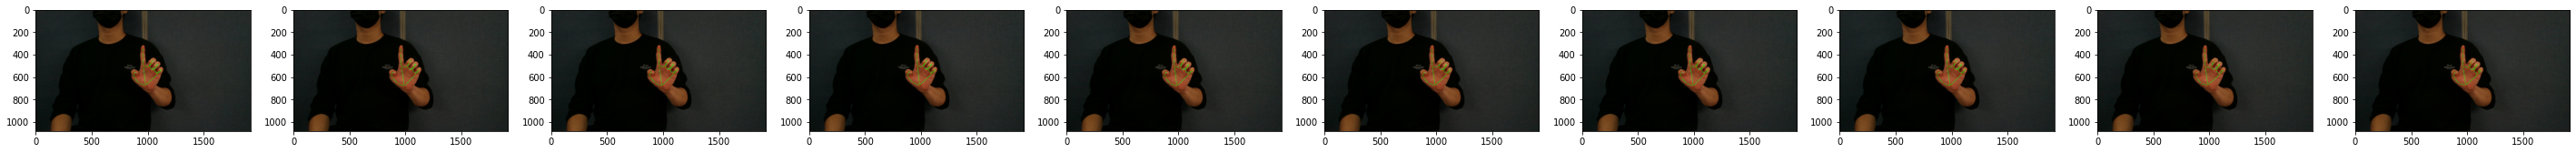

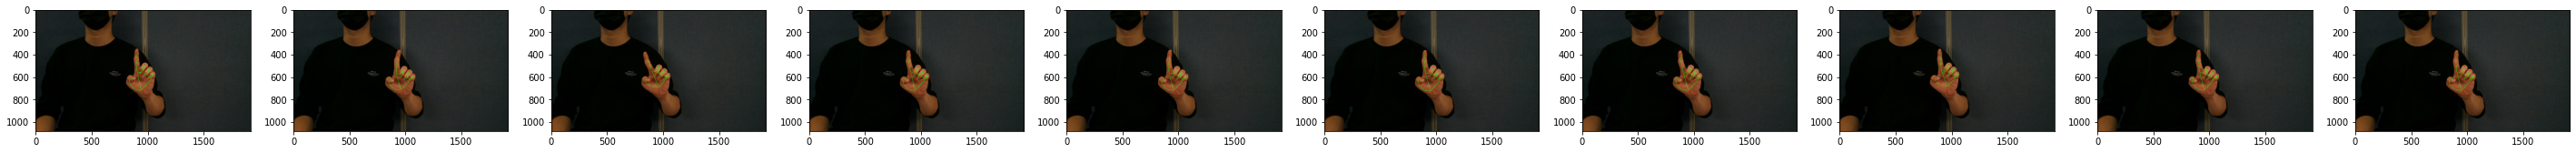

(None, None)

In [16]:
# 숫자1 & 부정(검지 흔들기) 폴더 시각화
visualize(352), visualize(489)

- 위 문제를 해결하기 위해 폴더 내 모든 이미지를 살펴보면 숫자1(352번)의 경우에는 전체적인 위치만 조금바뀌고 손가락 모양은 유지하는 것을 볼 수 있습니다. 
- 반면에 검지 흔들기(489번)의 경우는 검지가 움직이는 것(2번째 줄 3번째 이미지)을 확인할 수 있습니다.
- 이처럼 두 폴더의 이미지 각각을 놓고보면 클래스를 구별하기 어렵지만, 폴더 내 이미지 변화(손가락 움직임)를 통해 클래스를 구별할 수 있었습니다. 

### (Case 2) 두 번째는 주먹쥐기와 경고(주먹 내밀기) 대해서도 큰 Logloss값이 발생한 것을 볼 수 있습니다.

아래 시각화를 보시면 두 이미지는 각각 주먹쥐기와 경고(주먹 내밀기) Class입니다.

505 577


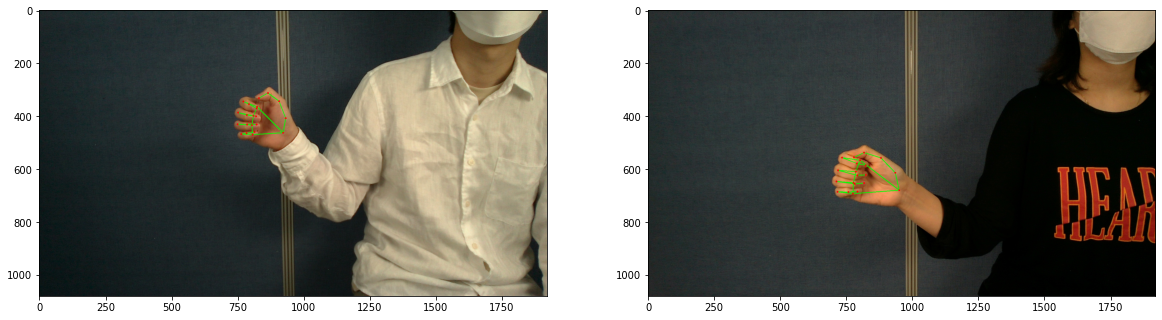

In [17]:
path = f'../data/train/'
number1_folder = df[df['answer_name'] == '주먹쥐기']['groups'].tolist()
shake_folder = df[df['answer_name'] == '경고(주먹 내밀기)']['groups'].tolist()

image1 = Image.open(opj(path, number1_folder[1], '1.png'))   # 505번 폴더
image2 = Image.open(opj(path, shake_folder[9], '1.png'))    # 577번 폴더
print(number1_folder[1], shake_folder[9])

fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(image1)
ax[1].imshow(image2)
plt.show()

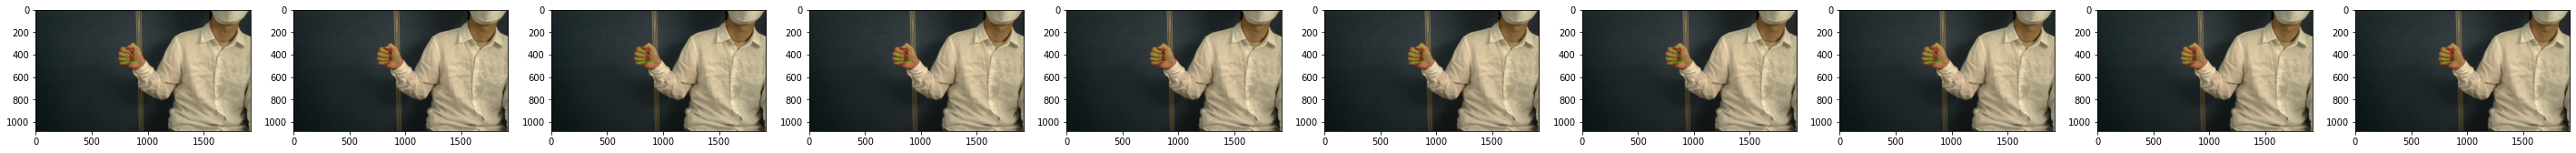

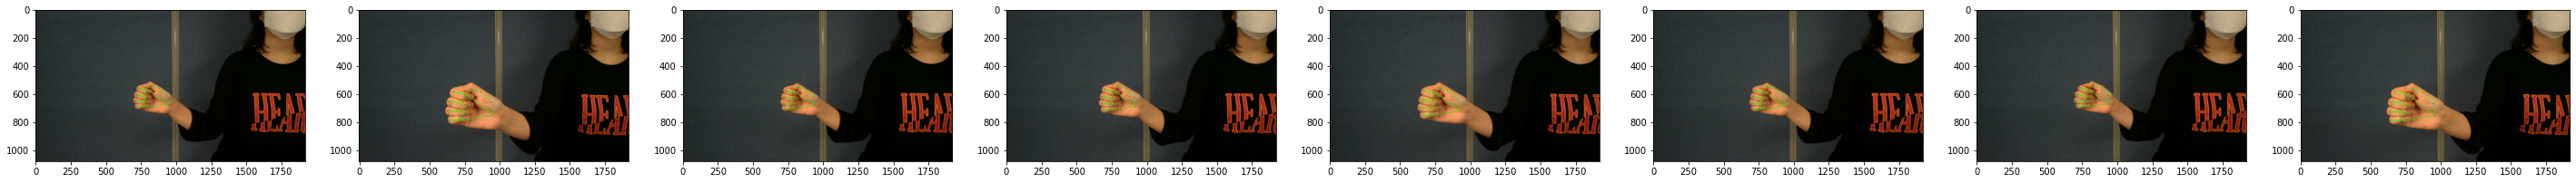

(None, None)

In [18]:
# 주먹쥐기 & 경고(주먹 내밀기) 폴더 시각화
visualize(505), visualize(577)

- (숫자1, 검지흔들기)pair와 마찬가지로 단순히 두 이미지만 봤을때는 어떤 클래스인지 판단하기가 어렵습니다.
- 폴더 내 모든 이미지를 살펴보면, 주먹쥐기의 경우에는 계속 같은 위치에서 크게 움직임이 없지만 주먹 내밀기의 경우에는 주먹이 카메라에 가까워졌다 멀어졌다 하는식으로 촬영된 것을 확인할 수 있었습니다.
- 이처럼 2개의 Case에 대해, 각 클래스를 구분하기 위해 추가적인 처리가 필요하다고 판단했습니다.

- 위의 2가지 Case를 해결하기 위해 생각해본 방법은 2가지가 있었습니다.

- 1) 폴더 내 이미지들의 Sequence를 살려서, 한 번의 입력에 여러 장의 이미지가 들어가 모델이 학습하도록 하는 방법
    - 해당 방법을 시도해보려고 했으나, 대회 막판에 위와 같은 문제를 발견하게되어 시간적인 여유가 없어서 구현해보지는 못했습니다.
    - 위 방법은 (a)시퀀스를 어느 정도의 길이로 만들어주느냐, (b)각 폴더 내에서 시퀀스 Pair를 얼마나 잘 만들어주느냐(변화가 있는 Class의 경우) 같은 Pre-processing에 영향을 크게 받지 않을까 생각합니다.


- 2) Keypoint를 사용한 Rule에 기반한 접근 방법
    - 본 대회는 Train과 Test모두 입력으로 이미지뿐만 아니라 Keypoint를 사용할 수 있었습니다. 따라서, 기존에 학습했던 것처럼 모델의 학습과 추론을 수행합니다.
    - 다만, 추론 시에 (숫자1, 검지 흔들기), (주먹쥐기, 주먹 내밀기) 두 Case 중에 하나의 Class를 예측하면 Keypoint를 사용한 Rule로 처리하는 방법입니다.
    - 예를 들어, 모델이 숫자1(왼손, My View) 또는 검지 흔들기(왼손, My View)로 예측하였으면, Keypoint에 기반한 알고리즘으로 넘어가게되고 해당 알고리즘을 거친 예측 정답이 나오게 됩니다.
    - 추가적으로, 해당 Task는 같은 숫자1이라도 왼손인지 오른손인지, 또는 My View인지 Your View에 따라 Class가 다릅니다.
    - 저희는 모델이 왼손인지 오른손인지, 또는 My View인지 Your View인지는 맞췄을거라 판단하였고, (숫자1(왼손, My View) - 검지 흔들기(왼손, My View))과 같이 좌우, View타입은 동일하게 매핑시켰습니다.

## Post-Processing in detail (Method)
### Case1
숫자1과 부정(검지 흔들기)의 경우 한 폴더 내에서 숫자1은 검지의 움직임이 크지 않지만 검지 흔들기는 검지를 흔들어야하기 때문에 검지 Keypoint의 X좌표로의 움직임이 상대적으로 클 수 밖에 없습니다. <br>
따라서, 손가락(검지)의 가장 위에 있는(0,0픽셀을 기준으로 Y값이 가장 작은) keypoint의 움직임을 통해 구별하고자 했습니다. <br>
예를들어, 폴더내 이미지가 10개가 있다면 10개의 검지 Keypoint 좌표가 있게 되고 해당 x좌표들에 대해서 max-min을 계산하게 됩니다.
즉, 각 폴더내에서 1개의 x좌표 변화량이 계산됩니다.<br>
두 클래스에 대해 계산된 검지 x좌표 변화량들에 대해서 적절한 threshold값을 설정해 클래스를 구분짓게 하였습니다. <br>

### Case2
주먹쥐기와 주먹 내밀기 같은 경우 손의 움직임을 통해 구별하고자 했습니다.
이는 단순하게 keypoint중 가장 오른쪽 x좌표의 변화량을 계산했습니다. <br>
Case1과 마찬가지로 keypoint의 x좌표 max-min을 계산했습니다. <br>
두 클래스에 대해 계산된 x좌표 변화량들에 대해서 적절한 threshold값을 설정해 두 클래스를 구분짓게 하였습니다.

In [19]:
# threshold를 계산하기 위해 각 case에 대한 변화량을 계산하는 함수 정의
def check_stats(find_list, ver):
    train_path = '../data/train'
    train_folders = natsorted(glob(train_path + '/*'))
    stat_list = []
    for _, train_folder in tqdm(enumerate(train_folders)):
        try:
            json_path = glob(train_folder + '/*.json')[0]
            js = json.load(open(json_path))
            cat = js.get('action')[0]
            keypoints = js['annotations']
            keypoints = np.array([point['data'] for point in keypoints])  # (N-이미지개수, 21 or 42(keypoints), 3(x,y,z 좌표))
        except:
            pass
            # print(train_folder)
        if cat in find_list:
            # 숫자1과 검지흔들기 구분 # Case1
            # 검지는 이미지내 keypoints들 중 가장 작은 y값(이미지 상 가장 높은 위치)을 갖는 point임. 
            # 해당 point의 x값을 뽑음.
            if ver ==1 : 
                keypoints = keypoints[:, :, :2]  # keypoints : (N, 21 or 42, 2)
                x_I_finger = [point_per_img[:,0][point_per_img[:,1].argmin()] for point_per_img in keypoints] # (N, 2) Y축으로 가장 작은 포인트 두개 추출
                stat_list.append(np.max(x_I_finger) - np.min(x_I_finger))
            
            # 주먹쥐기와 주먹 내밀기(경고) # Case2
            # keypoints들 중 가장 큰 x값(이미지 상 가장 우측 위치)을 갖는 point임.
            # Case2같은 경우는 left손목이 없기때문에 해당 logic이 잘 작동함.
            elif ver == 2:
                keypoints = keypoints[:, :, 0]   
                x_values = [point_per_img[point_per_img.argmax()] for point_per_img in keypoints]  # 가장 오른쪽
                stat_list.append(np.max(x_values) - np.min(x_values))

    print(stat_list)
    return stat_list

##label##
############ ver1 ###############
find_list0 = [0, 10, 100, 110] # ['숫자 1', '숫자1']  my hand, your hand 좌우
find_list1= [42, 67, 142, 167] # ['부정(검지 흔들기)'] my hand, your hand 좌우

############ ver2 ###############
find_list2 = [146] # ['주먹쥐기']  Your hand 우
find_list3 = [163] # ['경고(주먹 내밀기)'] Your hand 우

find_list4 = [171] # ['주먹쥐기']  Your hand Both
find_list5 = [191] # ['경고(주먹 내밀기)'] Your hand Both

### Case1
- 아래와 같이 Train dataset 내 두 클래스간 검지 위치 변화량 차이가 분명함을 확인할 수 있습니다.
- 하지만 부정(검지 흔들기)클래스의 특정 폴더에서 9.58, 20.37과 같은 작은 값들도 존재하였는데 해당 폴더를 살펴보면 손가락의 움직임이 거의 없어 숫자 1이라고 판단해도 될만한 노이즈인 경우가 있었습니다.
- 따라서, 해당 threshold로는 완벽한 구분이 불가능 할 수 있지만, 두 Outlier를 제외하면 움직임 값이 매우 크기 때문에 숫자1의 움직임들 중 Max값인 26.85에 어느정도의 Margin(5)을 주었습니다.

In [20]:
# 숫자1 & 검지 흔들기
li0 = check_stats(find_list0,1)  #숫자1 or 숫자 1
li1 = check_stats(find_list1,1)  #부정(검지 흔들기)
threshold_ver1 = max(li0) + 5    # Margin 5
print(f'\n{threshold_ver1:.3f}보다 크면 부정(검지 흔들기) 클래스')

649it [00:00, 3431.44it/s]


[8.119010925292969, 6.710529327392578, 10.130081176757812, 25.8563232421875, 13.067092895507812, 6.2530517578125, 26.8505859375, 6.2162017822265625, 5.463695526123047, 11.729393005371094, 11.357345581054688, 3.2952117919921875, 2.7133941650390625]


649it [00:00, 3358.39it/s]

[205.29773712158203, 202.2853660583496, 181.16334915161133, 193.3260726928711, 146.09790802001953, 219.83436584472656, 201.2340545654297, 162.94750213623047, 149.35192108154297, 171.31982803344727, 128.1661605834961, 97.09001541137695, 20.372543334960938, 151.41706466674805, 151.18257522583008, 134.03549194335938, 53.82728576660156, 124.27928924560547, 9.581222534179688, 124.74632263183594]

31.851보다 크면 부정(검지 흔들기) 클래스


### Case2
- 아래와 같이 두 클래스간 가장 큰 x좌표의 위치 변화량 차이가 분명함을 확인할 수 있습니다.
- 하지만 주먹쥐기(596번 폴더) 클래스인데 주먹을 활짝 펴버리는(첫번째 이미지) 노이즈 이미지가 존재하였습니다. 해당 이미지 때문에 596번 폴더의 x좌표 변화량이 매우 크게 나타남을 확인할 수 있습니다.
- 따라서 596번 폴더는 제외하고 threshold를 구하였습니다.

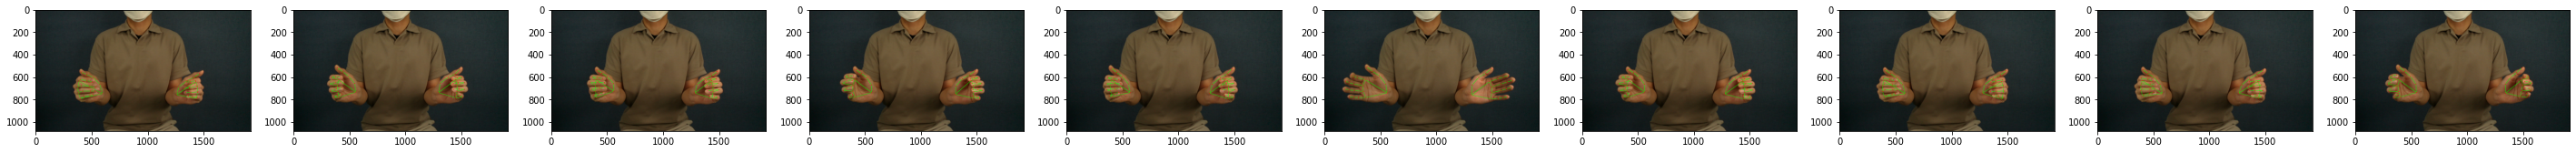

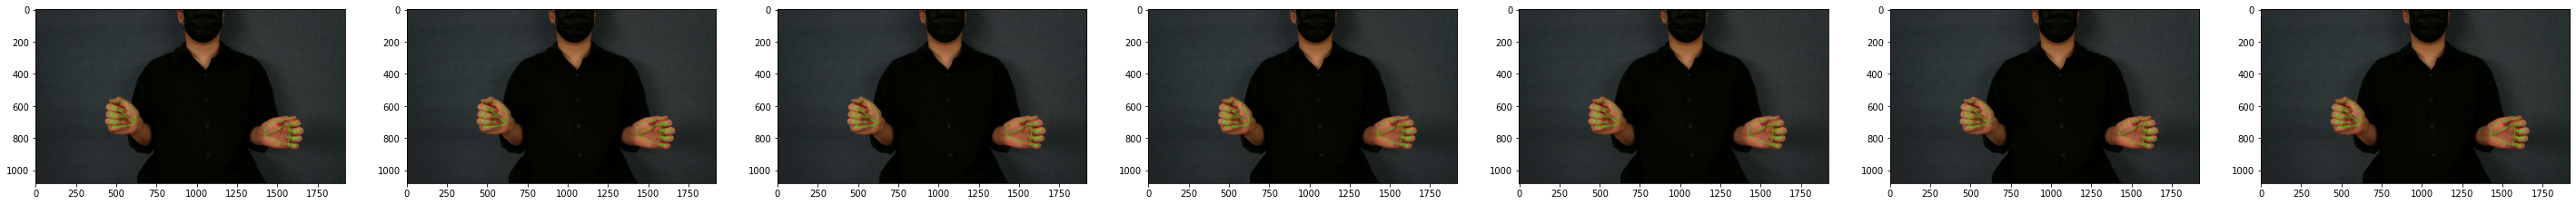

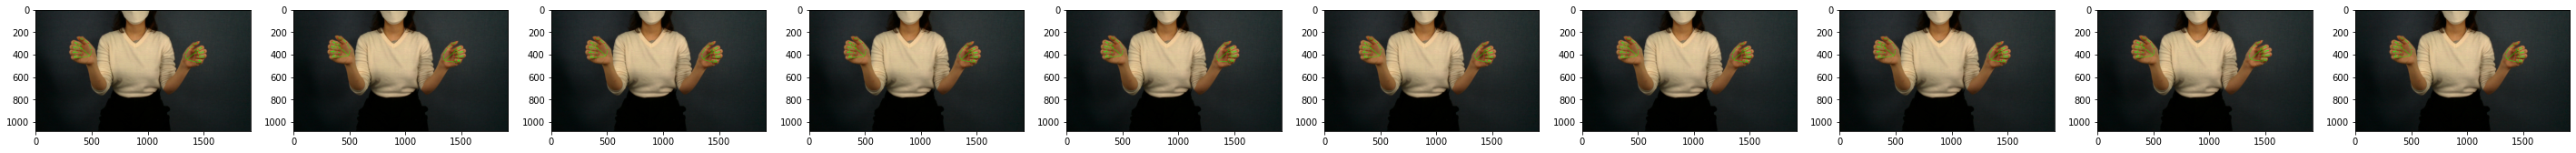

(None, None, None)

In [21]:
visualize(596), visualize(597), visualize(598)

In [22]:
# 주먹쥐기 vs 주먹 내밀기 Right
li2 = check_stats(find_list2,2)   
li3 = check_stats(find_list3,2)   
threshold_ver2 = max(li2) + 5       # Margin 5
print(f'\n{threshold_ver2:.3f}보다 크면 주먹 내밀기(right) 클래스')

# 주먹쥐기 vs 주먹 내밀기 Both
li4 = check_stats(find_list4,2)   
li4 = li4[1:]                       # 596번 폴더 변화량(218.313) Outlier -> 제외
li5 = check_stats(find_list5,2)   
threshold_ver2_both = max(li4) + 5  # Margin 5
print(f'\n{threshold_ver2_both:.3f}보다 크면 주먹 내밀기(both) 클래스')

### Case2에서 Both와 Right를 구분하여 threshold를 구하고자 했지만 큰 차이가 없어서 실제 inference시에는 통합함. ###

649it [00:00, 3444.31it/s]


[7.338523864746094, 7.1413421630859375, 24.80083465576172, 8.968505859375]


649it [00:00, 3463.12it/s]


[52.795257568359375, 201.94839477539062, 34.79106903076172, 55.388145446777344, 36.262779235839844]

29.801보다 크면 주먹 내밀기(right) 클래스


649it [00:00, 3477.84it/s]


[218.31310272216797, 6.470375061035156, 29.33704376220703]


649it [00:00, 3459.57it/s]

[286.4274215698242, 337.5590515136719, 103.0282974243164]

34.337보다 크면 주먹 내밀기(both) 클래스


## Stratified KFold
- 앞서 Stratified GroupKFold로 데이터를 Split하여 오류가 심한 클래스에 대한 분석을 수행할 수 있었습니다.
- 다만, Stratified GroupKFold 방법은 여전히 각 클래스당 폴더 개수가 너무 적기 때문인지 Validation Loss 기준으로 더 좋은 성능을 얻지는 못하였습니다.
- 그래서 처음에 StratifiedGroupKFold를 사용하려했던 선택을 바꾸어, 클래스 비율을 고려하여 랜덤하게 섞어주는 Stratified KFold를 사용하였고 Public에서 더 좋은 Score를 얻게 되었습니다.

## Main Function

In [23]:
def main(args):
    # Random Seed
    seed = args.seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

    save_path = os.path.join(args.model_path, (args.exp_num).zfill(3))
    # Create model directory
    os.makedirs(save_path, exist_ok=True)
    Trainer(args, save_path)

In [27]:
if __name__ == '__main__':
    for i in range(5):  # 5Folds Training
        args.fold = i
        args.exp_num = str(i)
        main(args)

2021-10-18 03:06:40,736 INFO: {'exp_num': '10', 'experiment': 'Base', 'tag': 'Default', 'data_path': '../data', 'fold': 0, 'Kfold': 5, 'model_path': 'results/', 'encoder_name': 'regnety_040', 'drop_path_rate': 0.2, 'img_size': 288, 'batch_size': 16, 'epochs': 60, 'optimizer': 'Lamb', 'initial_lr': 5e-06, 'weight_decay': 0.001, 'aug_ver': 2, 'flipaug_ratio': 0.3, 'margin': 50, 'random_margin': True, 'scheduler': 'cycle', 'warm_epoch': 5, 'min_lr': 5e-06, 'tmax': 145, 'max_lr': 0.001, 'patience': 50, 'clipping': None, 'amp': True, 'multi_gpu': False, 'logging': False, 'num_workers': 4, 'seed': 42}
2021-10-18 03:06:40,736 INFO: Default
2021-10-18 03:06:41,086 INFO: Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_040-f0d569f9.pth)


Mapping dataframe Length (53, 5)
Use Flip Augmentation
Dataset size:4828
Dataset size:1207


2021-10-18 03:06:41,209 INFO: Computational complexity:       6.58 GMac
2021-10-18 03:06:41,210 INFO: Number of parameters:           19.73 M 
100%|██████████| 302/302 [00:49<00:00,  6.13it/s]
2021-10-18 03:07:30,505 INFO: Epoch:[001/060]
2021-10-18 03:07:30,506 INFO: Train Loss:5.152 | Acc:0.0052
2021-10-18 03:07:42,112 INFO: Valid Loss:5.127 | Acc:0.0099
2021-10-18 03:07:42,468 INFO: -----------------SAVE:1epoch----------------
100%|██████████| 302/302 [00:49<00:00,  6.11it/s]
2021-10-18 03:08:31,901 INFO: Epoch:[002/060]
2021-10-18 03:08:31,902 INFO: Train Loss:5.134 | Acc:0.0041
2021-10-18 03:08:43,453 INFO: Valid Loss:5.111 | Acc:0.0108
2021-10-18 03:08:43,800 INFO: -----------------SAVE:2epoch----------------
100%|██████████| 302/302 [00:49<00:00,  6.11it/s]
2021-10-18 03:09:33,222 INFO: Epoch:[003/060]
2021-10-18 03:09:33,222 INFO: Train Loss:5.144 | Acc:0.0046
2021-10-18 03:09:44,777 INFO: Valid Loss:5.109 | Acc:0.0099
2021-10-18 03:09:45,122 INFO: -----------------SAVE:3epoch-

Mapping dataframe Length (53, 5)
Use Flip Augmentation
Dataset size:4828
Dataset size:1207


2021-10-18 04:08:23,517 INFO: Computational complexity:       6.58 GMac
2021-10-18 04:08:23,518 INFO: Number of parameters:           19.73 M 
100%|██████████| 302/302 [00:50<00:00,  5.94it/s]
2021-10-18 04:09:14,390 INFO: Epoch:[001/060]
2021-10-18 04:09:14,391 INFO: Train Loss:5.150 | Acc:0.0050
2021-10-18 04:09:25,931 INFO: Valid Loss:5.130 | Acc:0.0091
2021-10-18 04:09:26,160 INFO: -----------------SAVE:1epoch----------------
100%|██████████| 302/302 [00:49<00:00,  6.07it/s]
2021-10-18 04:10:15,898 INFO: Epoch:[002/060]
2021-10-18 04:10:15,899 INFO: Train Loss:5.137 | Acc:0.0043
2021-10-18 04:10:27,433 INFO: Valid Loss:5.118 | Acc:0.0083
2021-10-18 04:10:27,842 INFO: -----------------SAVE:2epoch----------------
100%|██████████| 302/302 [00:49<00:00,  6.05it/s]
2021-10-18 04:11:17,746 INFO: Epoch:[003/060]
2021-10-18 04:11:17,746 INFO: Train Loss:5.142 | Acc:0.0062
2021-10-18 04:11:29,361 INFO: Valid Loss:5.110 | Acc:0.0124
2021-10-18 04:11:29,714 INFO: -----------------SAVE:3epoch-

Mapping dataframe Length (53, 5)
Use Flip Augmentation
Dataset size:4828
Dataset size:1207


2021-10-18 05:10:17,520 INFO: Computational complexity:       6.58 GMac
2021-10-18 05:10:17,520 INFO: Number of parameters:           19.73 M 
100%|██████████| 302/302 [00:50<00:00,  5.96it/s]
2021-10-18 05:11:08,208 INFO: Epoch:[001/060]
2021-10-18 05:11:08,209 INFO: Train Loss:5.147 | Acc:0.0052
2021-10-18 05:11:19,737 INFO: Valid Loss:5.117 | Acc:0.0133
2021-10-18 05:11:19,971 INFO: -----------------SAVE:1epoch----------------
100%|██████████| 302/302 [00:50<00:00,  5.96it/s]
2021-10-18 05:12:10,650 INFO: Epoch:[002/060]
2021-10-18 05:12:10,650 INFO: Train Loss:5.144 | Acc:0.0058
2021-10-18 05:12:22,250 INFO: Valid Loss:5.108 | Acc:0.0108
2021-10-18 05:12:22,594 INFO: -----------------SAVE:2epoch----------------
100%|██████████| 302/302 [00:50<00:00,  5.97it/s]
2021-10-18 05:13:13,147 INFO: Epoch:[003/060]
2021-10-18 05:13:13,147 INFO: Train Loss:5.144 | Acc:0.0056
2021-10-18 05:13:24,800 INFO: Valid Loss:5.101 | Acc:0.0099
2021-10-18 05:13:25,156 INFO: -----------------SAVE:3epoch-

Mapping dataframe Length (53, 5)
Use Flip Augmentation
Dataset size:4828
Dataset size:1207


2021-10-18 06:12:11,305 INFO: Computational complexity:       6.58 GMac
2021-10-18 06:12:11,306 INFO: Number of parameters:           19.73 M 
100%|██████████| 302/302 [00:50<00:00,  5.97it/s]
2021-10-18 06:13:01,898 INFO: Epoch:[001/060]
2021-10-18 06:13:01,899 INFO: Train Loss:5.153 | Acc:0.0050
2021-10-18 06:13:13,496 INFO: Valid Loss:5.128 | Acc:0.0099
2021-10-18 06:13:13,742 INFO: -----------------SAVE:1epoch----------------
100%|██████████| 302/302 [00:49<00:00,  6.10it/s]
2021-10-18 06:14:03,273 INFO: Epoch:[002/060]
2021-10-18 06:14:03,274 INFO: Train Loss:5.132 | Acc:0.0056
2021-10-18 06:14:14,863 INFO: Valid Loss:5.112 | Acc:0.0075
2021-10-18 06:14:15,215 INFO: -----------------SAVE:2epoch----------------
100%|██████████| 302/302 [00:50<00:00,  5.97it/s]
2021-10-18 06:15:05,836 INFO: Epoch:[003/060]
2021-10-18 06:15:05,836 INFO: Train Loss:5.144 | Acc:0.0039
2021-10-18 06:15:17,405 INFO: Valid Loss:5.110 | Acc:0.0099
2021-10-18 06:15:17,746 INFO: -----------------SAVE:3epoch-

Mapping dataframe Length (53, 5)
Use Flip Augmentation
Dataset size:4828
Dataset size:1207


2021-10-18 07:14:02,842 INFO: Computational complexity:       6.58 GMac
2021-10-18 07:14:02,843 INFO: Number of parameters:           19.73 M 
100%|██████████| 302/302 [00:50<00:00,  5.98it/s]
2021-10-18 07:14:53,310 INFO: Epoch:[001/060]
2021-10-18 07:14:53,310 INFO: Train Loss:5.156 | Acc:0.0062
2021-10-18 07:15:04,927 INFO: Valid Loss:5.126 | Acc:0.0099
2021-10-18 07:15:05,185 INFO: -----------------SAVE:1epoch----------------
100%|██████████| 302/302 [00:49<00:00,  6.12it/s]
2021-10-18 07:15:54,506 INFO: Epoch:[002/060]
2021-10-18 07:15:54,507 INFO: Train Loss:5.136 | Acc:0.0058
2021-10-18 07:16:06,011 INFO: Valid Loss:5.108 | Acc:0.0124
2021-10-18 07:16:06,359 INFO: -----------------SAVE:2epoch----------------
100%|██████████| 302/302 [00:49<00:00,  6.10it/s]
2021-10-18 07:16:55,900 INFO: Epoch:[003/060]
2021-10-18 07:16:55,900 INFO: Train Loss:5.146 | Acc:0.0052
2021-10-18 07:17:07,372 INFO: Valid Loss:5.105 | Acc:0.0099
2021-10-18 07:17:07,747 INFO: -----------------SAVE:3epoch-

## Inference with Ensemble
- 위에서 구한 threshold를 이용하여 Rule Base inference를 구축할 수 있었습니다.
- replace_dict이라는 변수를 통해 헷갈리는 두 클래스를 매칭하였습니다.

In [31]:
# test의 keypoints(json) 변화량 구하기 위한 함수 정의
def Refiner(keypoints, ver):
    keypoints = np.array([point['data'] for point in keypoints]) 
    # 숫자1과 검지흔들기 구분
    if ver == 1:  
        keypoints = keypoints[:, :, :2]  
        x_I_finger = [point_per_img[:,0][point_per_img[:,1].argmin()] for point_per_img in keypoints]
        query_value = np.max(x_I_finger) - np.min(x_I_finger)
    
    # 주먹쥐기와 주먹 내밀기(경고) 
    elif ver == 2:
        keypoints = keypoints[:, :, 0]  
        x_values = [point_per_img[point_per_img.argmax()] for point_per_img in keypoints]
        query_value = np.max(x_values) - np.min(x_values)
    
    return query_value

### Download the Pretrained Weight (./results/ 경로에)

In [39]:
os.makedirs('./results/', exist_ok=True)
!wget -i https://raw.githubusercontent.com/wooseok-shin/Egovision-1st-place-solution/main/load_pretrained.txt -P results   
# MLP is All You Need님 Kernel을 참고하였습니다. 감사합니다. (https://dacon.io/competitions/official/235805/codeshare/3613?page=1&dtype=recent)


--2021-10-18 16:44:11--  https://raw.githubusercontent.com/wooseok-shin/Egovision-1st-place-solution/main/load_pretrained.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
접속 raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 666 [text/plain]
Saving to: ‘results/load_pretrained.txt’

load_pretrained.txt 100%[===================>]     666  --.-KB/s    in 0s      

2021-10-18 16:44:11 (56.3 MB/s) - ‘results/load_pretrained.txt’ saved [666/666]

--2021-10-18 16:44:11--  https://github.com/wooseok-shin/Egovision-1st-place-solution/releases/download/best_model/single_best_model.pth
Resolving github.com (github.com)... 52.78.231.108
접속 github.com (github.com)|52.78.231.108|:443... 접속됨.
HTTP request sent, awaiting response... 302 Found
Location: https://github-releases.githubusercontent.com/417896100/fd2cbbf4-ffe6-4931-bd7c-3878df62

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_path = f'../data/test' 
test_folders = natsorted(glob(test_path + '/*'))

args = easydict.EasyDict({'encoder_name':'regnety_040',
                        'drop_path_rate':0,
                        })

load_pretrain = True        # Use Pretrained weights
ensemble_test = True        # Ensemble or Single
refine = True              # Use Refiner (Rule-base)


if load_pretrain:  # Github로부터 Pretrained Weight Load
    model_path0 = './results/0Fold_model.pth' # fold0
    model_path1 = './results/1Fold_model.pth' # fold1
    model_path2 = './results/2Fold_model.pth' # fold2
    model_path3 = './results/3Fold_model.pth' # fold3
    model_path4 = './results/4Fold_model.pth' # fold4

else:  # 위에서 학습한 모델 Weight Load
    model_path0 = './results/000/best_model.pth' # fold0
    model_path1 = './results/001/best_model.pth' # fold1
    model_path2 = './results/002/best_model.pth' # fold2
    model_path3 = './results/003/best_model.pth' # fold3
    model_path4 = './results/004/best_model.pth' # fold4


# 5Fold Ensemble
if ensemble_test:
    model0 = Pose_Network(args).to(device)
    model0.load_state_dict(torch.load(model_path0)['state_dict'])
    model0.eval()

    model1 = Pose_Network(args).to(device)
    model1.load_state_dict(torch.load(model_path1)['state_dict'])
    model1.eval()

    model2 = Pose_Network(args).to(device)
    model2.load_state_dict(torch.load(model_path2)['state_dict'])
    model2.eval()

    model3 = Pose_Network(args).to(device)
    model3.load_state_dict(torch.load(model_path3)['state_dict'])
    model3.eval()

    model4 = Pose_Network(args).to(device)
    model4.load_state_dict(torch.load(model_path4)['state_dict'])
    model4.eval()

    model_list = [model0, model1, model2, model3, model4]

else:  # Single Best Model (Using the pretrained weight)
    model_path = './results/single_best_model.pth'
    single_best = Pose_Network(args).to(device)
    single_best.load_state_dict(torch.load(model_path)['state_dict'])
    single_best.eval()
    model_list = [single_best]


img_size = 288
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((img_size, img_size)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        ])

sub = pd.read_csv('../data/sample_submission.csv')
df_info = pd.read_csv('../data/hand_gesture_pose.csv')
le = LabelEncoder()
le.fit(df_info['pose_id'])
trans = le.transform

# Class Mapping dict
ver1_list = trans([0, 42, 10, 67, 100, 142, 110, 167])   
ver2_list = trans([146, 163, 171, 191])
replace_dict = {146:163, 171:191, 0:42, 10:67, 100:142, 110:167}
replace_dict = dict([trans(x) for x in list(replace_dict.items())])   # Mapping (Origin:0~195 to 0~156)

total_list = np.concatenate([ver1_list, ver2_list]).tolist()


for i, test_folder in tqdm(enumerate(test_folders)):
    dir = os.path.dirname(test_folder)
    folder_num = os.path.basename(test_folder)
    json_path = opj(dir, folder_num, folder_num+'.json')
    js = json.load(open(json_path))
    keypoints = js['annotations']  # 해당 이미지에 해당하는 Keypoints
    images_list = natsorted(glob(test_folder + '/*.png'))
    images = []
    for _, (point, image_name) in enumerate(zip(keypoints, images_list)):
        croped_image = crop_image(image_name, point, margin=100)
        image = transform(croped_image)
        images.append(image)

    images = torch.stack(images).to(device)
    ensemble = np.zeros((157,), dtype=np.float32)
    for model in model_list:
        preds = model(images)
        preds = torch.softmax(preds, dim=1)
        preds = torch.mean(preds, dim=0).detach().cpu().numpy()    # shape:(157,)
        ensemble += preds
    preds = ensemble / len(model_list)
    pred_class = preds.argmax().item()
    if refine and (pred_class in total_list):
        idx = list(replace_dict.keys()).index(pred_class) if pred_class in replace_dict.keys() else list(replace_dict.values()).index(pred_class)
        cand1, cand2 = list(replace_dict.items())[idx]

        if pred_class in ver1_list:
            query_value = Refiner(keypoints, ver=1)
            answer = cand1 if query_value < threshold_ver1 else cand2

        elif pred_class in ver2_list:
            query_value = Refiner(keypoints, ver=2)
            answer = cand1 if query_value < threshold_ver2_both else cand2

        preds[answer] = 1
        preds = np.where(preds != 1, 0, preds)  # Refiner를 통해 나온 class를 제외한 나머지의 확률값은 모두 0으로 변환

    sub.iloc[i, 1:] = preds.astype(float)

sub.to_csv('./results/submission_train_add_ensemble_rule.csv',index=False)

2021-10-18 15:32:02,495 INFO: Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_040-f0d569f9.pth)
217it [01:06,  3.27it/s]
